In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tsfresh as tsf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [20]:
df = pd.read_csv("../data/kpi.csv")
df['ts']=pd.to_datetime(df['timestamp'], unit='s')
df.index = df['ts']
df = df[['ts', 'value', 'label']]
df.head()

,ts,value,label
ts,,,
2017-04-01 10:08:00,2017-04-01 10:08:00,7934.0,0
2017-04-01 10:09:00,2017-04-01 10:09:00,7782.0,0
2017-04-01 10:10:00,2017-04-01 10:10:00,7349.0,0
2017-04-01 10:11:00,2017-04-01 10:11:00,7426.0,0
2017-04-01 10:12:00,2017-04-01 10:12:00,7447.0,0


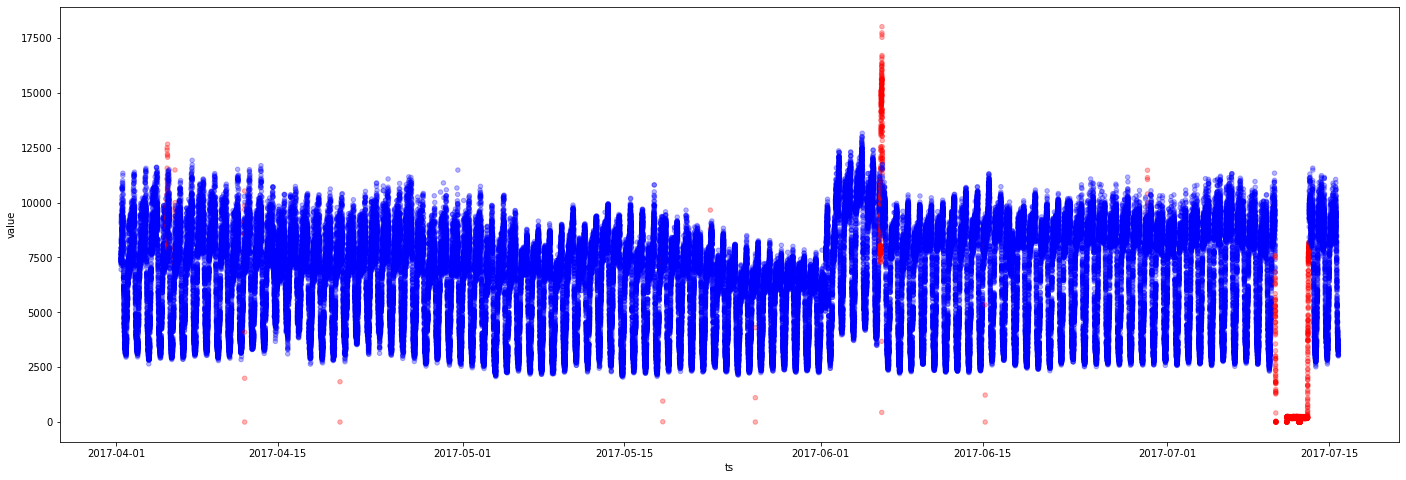

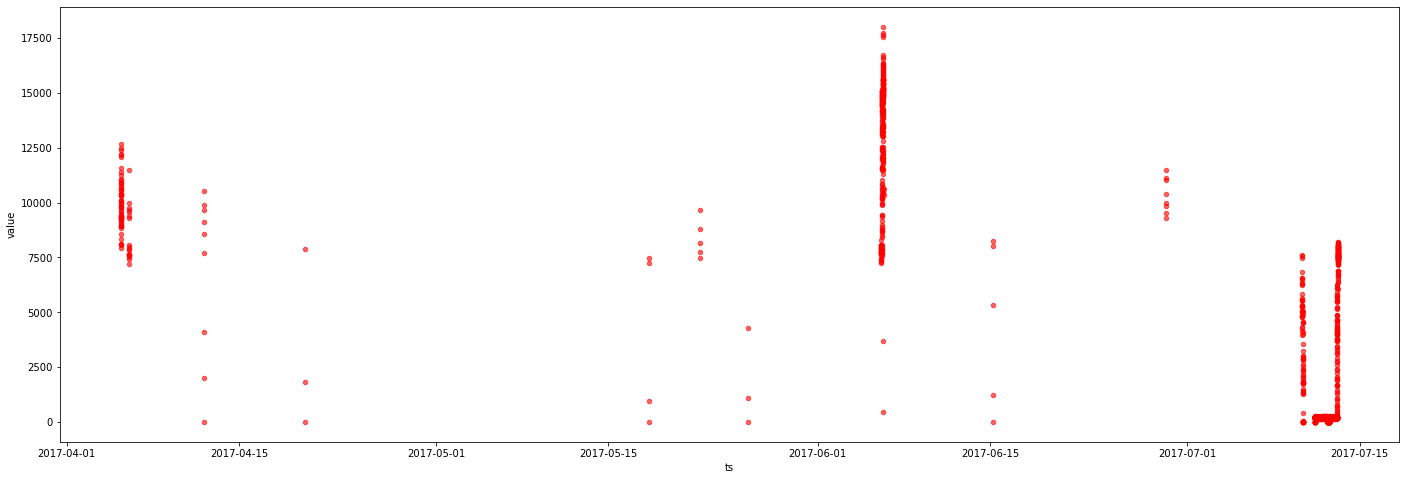

In [21]:
plt.rcParams['figure.figsize'] = (24,8)
df.plot(x="ts", y="value", kind="scatter", c=['b' if l==0 else 'r' for l in df["label"]], alpha=0.3)
df[df['label']==1].plot(x="ts", y="value", kind="scatter", c='r', alpha=0.6)
plt.show()

In [58]:
import pandas as pd
import numpy as np
import tsfresh as tsf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing


def extracted_features(df, n=10):
    df = ts_time_feature_generate(df)
    df = ts_exponential_smoothing_feature_generate(df)
    df = ts_rolling_statistics_feature_generate(df, n)
    df = ts_lag_feature_generate(df, n)
    df = ts_linear_feature_generate(df, n)
    df = ts_seasonal_decompose(df)
    df = ts_fft_feature_generate(df, n)
    df = ts_wavelet_feature_generate(df, n)
    df = ts_wavelet_feature_generate(df, n)
    return df


def ts_time_feature_generate(data_df):
    # 时间特性，要看训练数据的时间区间这些值是否有价值
    data_df['quarter'] = data_df['ts'].dt.quarter
    data_df['month'] = data_df['ts'].dt.month
    data_df['day'] = data_df['ts'].dt.day
    data_df['dayofweek'] = data_df['ts'].dt.dayofweek
    data_df['weekofyear'] = data_df['ts'].dt.isocalendar().week
    data_df['hour'] = data_df['ts'].dt.hour

    # 这些特征一般跟业务属性强关系
    data_df['is_year_start'] = data_df['ts'].dt.is_year_start.astype(np.int)
    data_df['is_year_end'] = data_df['ts'].dt.is_year_end.astype(np.int)
    data_df['is_quarter_start'] = data_df['ts'].dt.is_quarter_start.astype(np.int)
    data_df['is_quarter_end'] = data_df['ts'].dt.is_quarter_end.astype(np.int)
    data_df['is_month_start'] = data_df['ts'].dt.is_month_start.astype(np.int)
    data_df['is_month_end'] = data_df['ts'].dt.is_month_end.astype(np.int)
    data_df['is_weekend'] = data_df['dayofweek'].apply(lambda x: 1 if x == 0 or x == 6 else 0)

    # 是否时一天的高峰时段 8~18
    data_df['day_high'] = data_df['hour'].apply(lambda x: 1 if 8 < x < 18 else 0)
    # 是否是批跑时段
    data_df['day_night'] = data_df['hour'].apply(lambda x: 1 if 0 < x < 6 else 0)

    return data_df


def ts_rolling_statistics_feature_generate(data_df, n):
    data_df[f'rolling_{n}_avg'] = data_df["value"].rolling(n).mean()
    data_df[f'rolling_{n}_median'] = data_df["value"].rolling(n).median()
    data_df[f'rolling_{n}_max'] = data_df["value"].rolling(n).max()
    data_df[f'rolling_{n}_min'] = data_df["value"].rolling(n).min()
    data_df[f'rolling_{n}_std'] = data_df["value"].rolling(n).std()
    data_df[f'rolling_{n}_var'] = data_df["value"].rolling(n).var()

    def mad(x):
        return np.fabs(x - x.mean()).mean()

    data_df[f'rolling_{n}_mad'] = data_df["value"].rolling(n).apply(mad, raw=True)
    data_df[f'rolling_{n}_skew'] = data_df["value"].rolling(n).skew()
    data_df[f'rolling_{n}_kurt'] = data_df["value"].rolling(n).kurt()
    data_df[f'rolling_{n}_corr'] = data_df["value"].rolling(n).corr()
    data_df[f'rolling_{n}_cov'] = data_df["value"].rolling(n).cov()
    data_df[f'rolling_{n}_q1'] = data_df["value"].rolling(n).quantile(0.25)
    data_df[f'rolling_{n}_q3'] = data_df["value"].rolling(n).quantile(0.75)
    data_df[f'rolling_{n}_ewma'] = data_df["value"].ewm(span=n).mean()

    return data_df


def ts_lag_feature_generate(data_df, *lags):
    data_df[f'diff_1'] = data_df["value"] - data_df["value"].shift(1)
    data_df[f'diff_1'] = data_df[f'diff_1'].fillna(value=0.0)
    data_df[f'diff_2'] = data_df["diff_1"] - data_df["diff_1"].shift(1)
    data_df[f'diff_2'] = data_df[f'diff_2'].fillna(value=0.0)
    for n in lags:
        data_df[f'ago_{n}_diff_1'] = (data_df["value"] - data_df["value"].shift(n)).fillna(value=0)
    return data_df


def ts_linear_feature_generate(data_df, n):
    data_df[f'rolling_{n}_linear_trend_slope'] = data_df["value"].rolling(n) \
        .apply(
        lambda data: list(tsf.feature_extraction.feature_calculators.linear_trend(data, [{'attr': 'slope'}]))[0][1])
    data_df[f'rolling_{n}_linear_trend_intercept'] = data_df["value"].rolling(n) \
        .apply(
        lambda data: list(tsf.feature_extraction.feature_calculators.linear_trend(data, [{'attr': 'intercept'}]))[0][1])

    return data_df


def ts_exponential_smoothing_feature_generate(data_df, seasonal=1440):
    data_df['smoothing_1exp'] = SimpleExpSmoothing(data_df["value"]).fit(smoothing_level=0.5).fittedvalues
    data_df['smoothing_2exp'] = ExponentialSmoothing(data_df["value"], trend="add", seasonal=None).fit().fittedvalues
    data_df['smoothing_3exp'] = ExponentialSmoothing(data_df["value"], trend="add", seasonal="add",
                                                     seasonal_periods=seasonal).fit().fittedvalues
    return data_df

def ts_seasonal_decompose(data_df, seasonal=1440):
    result_mul = seasonal_decompose(data_df['value'], model='additive', extrapolate_trend='freq', period=seasonal)
    data_df['seasonal_decompose_trend'] = result_mul.trend
    data_df['seasonal_decompose_seasonal'] = result_mul.seasonal
    data_df['seasonal_decompose_resid'] = result_mul.resid
    return data_df


def ts_fft_feature_generate(data_df, n):
    data_df[f'rolling_{n}_fft_agg_centroid'] = data_df["value"].rolling(n) \
        .apply(lambda data:
               list(tsf.feature_extraction.feature_calculators.fft_aggregated(data, [{'aggtype': 'centroid'}]))[0][1])
    data_df[f'rolling_{n}_fft_agg_variance'] = data_df["value"].rolling(n) \
        .apply(lambda data:
               list(tsf.feature_extraction.feature_calculators.fft_aggregated(data, [{'aggtype': 'variance'}]))[0][1])
    # 一般生成的是空值，暂时删除
    # data_df[f'rolling_{n}_fft_agg_skew']=data_df["value"].rolling(n)\
    #    .apply(lambda data:list(tsf.feature_extraction.feature_calculators.fft_aggregated(data, [{'aggtype': 'skew'}]))[0][1])
    # data_df[f'rolling_{n}_fft_agg_kurtosis']=data_df["value"].rolling(n)\
    #    .apply(lambda data:list(tsf.feature_extraction.feature_calculators.fft_aggregated(data, [{'aggtype': 'kurtosis'}]))[0][1])
    data_df[f'rolling_{n}_fft_coeff_angle'] = data_df["value"].rolling(n) \
        .apply(lambda data:
               list(tsf.feature_extraction.feature_calculators.fft_coefficient(data, [{'coeff': 2, 'attr': 'angle'}]))[
                   0][1])
    data_df[f'rolling_{n}_fft_coeff_real'] = data_df["value"].rolling(n) \
        .apply(lambda data:
               list(tsf.feature_extraction.feature_calculators.fft_coefficient(data, [{'coeff': 2, 'attr': 'real'}]))[
                   0][1])
    data_df[f'rolling_{n}_fft_coeff_abs'] = data_df["value"].rolling(n) \
        .apply(lambda data:
               list(tsf.feature_extraction.feature_calculators.fft_coefficient(data, [{'coeff': 2, 'attr': 'abs'}]))[0][
                   1])
    data_df[f'rolling_{n}_fft_coeff_imag'] = data_df["value"].rolling(n) \
        .apply(lambda data:
               list(tsf.feature_extraction.feature_calculators.fft_coefficient(data, [{'coeff': 2, 'attr': 'imag'}]))[
                   0][1])

    return data_df


def ts_wavelet_feature_generate(data_df, n):
    data_df[f'rolling_{n}_wavelet_cwt_coeff'] = data_df["value"].rolling(n) \
        .apply(lambda data: list(tsf.feature_extraction.feature_calculators.cwt_coefficients(data, [
        {'widths': tuple([2, 2, 2]), 'coeff': 2, 'w': 2}]))[0][1])
    return data_df


In [59]:
featured_df = extracted_features(df)

/Users/renzhiqiang/miniforge3/envs/aiops/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/renzhiqiang/miniforge3/envs/aiops/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/renzhiqiang/miniforge3/envs/aiops/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/renzhiqiang/miniforge3/envs/aiops/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated

In [55]:
droped_na_df = featured_df[10:]

In [60]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

In [74]:
feature_all_columns = droped_na_df.columns[3:]
feature_all_columns = np.r_[feature_all_columns, ["value"]]


In [ ]:
rf_model = RandomForestRegressor(n_estimators=500, random_state=1)
rfe = RFE(n_features_to_select=8, estimator=rf_model)
fit = rfe.fit(droped_na_df.loc[:, feature_all_columns].values, droped_na_df["label"].values)

print('Selected Features:')
print(fit.support_)